# Лабораторная работа №7 (Проведение исследований моделями семантической сегментации)

## 1. Выбор начальных условий
### a. Набор данных для задачи классификации

Для выполнения данной работы был выбран датасет: https://www.kaggle.com/datasets/santurini/semantic-segmentation-drone-dataset/code

Набор данных семантической сегментации с помощью дронов может использоваться для тренировки моделей,  способных эффективно сегментировать различные объекты и сцены, захваченные с воздуха. Модель, обученная на таком датасете, может значительно улучшить анализ данных, полученных с дронов, его навигацию и будет полезна в таких областях, как сельское хозяйство, экология, градостроительство и многих других.

In [ ]:
!pip install kaggle
!pip install opendatasets
!pip install pandas
!pip install matplotlib
!pip install torch
!pip install torchvision
!pip install seaborn
!pip install scikit-learn
!pip install segmentation-models-pytorch
!pip installalbumentations

In [4]:
import opendatasets as od

od.download("https://www.kaggle.com/datasets/santurini/semantic-segmentation-drone-dataset/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: cojihbilliko
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/santurini/semantic-segmentation-drone-dataset


In [2]:
import numpy as np
import torch.nn as nn
import albumentations as A
from torch.utils.data import Dataset, DataLoader
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image
import segmentation_models_pytorch as smp

In [3]:
image_path = "semantic-segmentation-drone-dataset/classes_dataset/classes_dataset/original_images/"
mask_path = 'semantic-segmentation-drone-dataset/classes_dataset/classes_dataset/label_images_semantic/'

def create_df():
    name = []
    for dirname, _, filenames in os.walk(image_path):
        for filename in filenames:
            f = filename.split('.')[0]
            name.append(f)

    return pd.DataFrame({'id': name}, index = np.arange(0, len(name))).sort_values('id').reset_index(drop=True)

X = create_df()['id'].values

In [4]:
X_train, X_val = train_test_split(X, test_size=0.2, random_state=123)

print("Размер тренировочной выборки:", len(X_train))
print("Размер валидационной выборки:", len(X_val))

Размер тренировочной выборки: 320
Размер валидационной выборки: 80


In [5]:
class DroneDataset(Dataset):
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        image = np.array(Image.open(self.img_path + self.X[idx] + '.png'))
        mask = np.array(Image.open(self.mask_path + self.X[idx] + '.png'))

        if self.transform is not None:
            aug = self.transform(image=image, mask=mask)
            image = aug['image']
            mask = aug['mask']

        norm = A.Normalize()(image=image, mask=np.expand_dims(mask, 0))

        return norm['image'].transpose(2, 0, 1), norm['mask']

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def display_samples(dataset, num_samples=3):
    plt.figure(figsize=(14, 5 * num_samples))

    for i in range(num_samples):
        image, mask = dataset[i]

        image_np = np.array(image).transpose(1, 2, 0)
        image_np = np.clip(image_np, 0, 1)

        plt.subplot(num_samples, 2, i * 2 + 1)
        plt.imshow(image_np)
        plt.title(f'Image {i}')

        plt.subplot(num_samples, 2, i * 2 + 2)
        plt.imshow(np.array(mask).squeeze())
        plt.title(f'Mask {i}')

    plt.tight_layout()
    plt.show()

In [7]:
batch_size = 8

data_transforms = A.Compose([A.Resize(256, 256)])

train_dataset = DroneDataset(image_path, mask_path, X_train, data_transforms)
valid_dataset = DroneDataset(image_path, mask_path, X_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

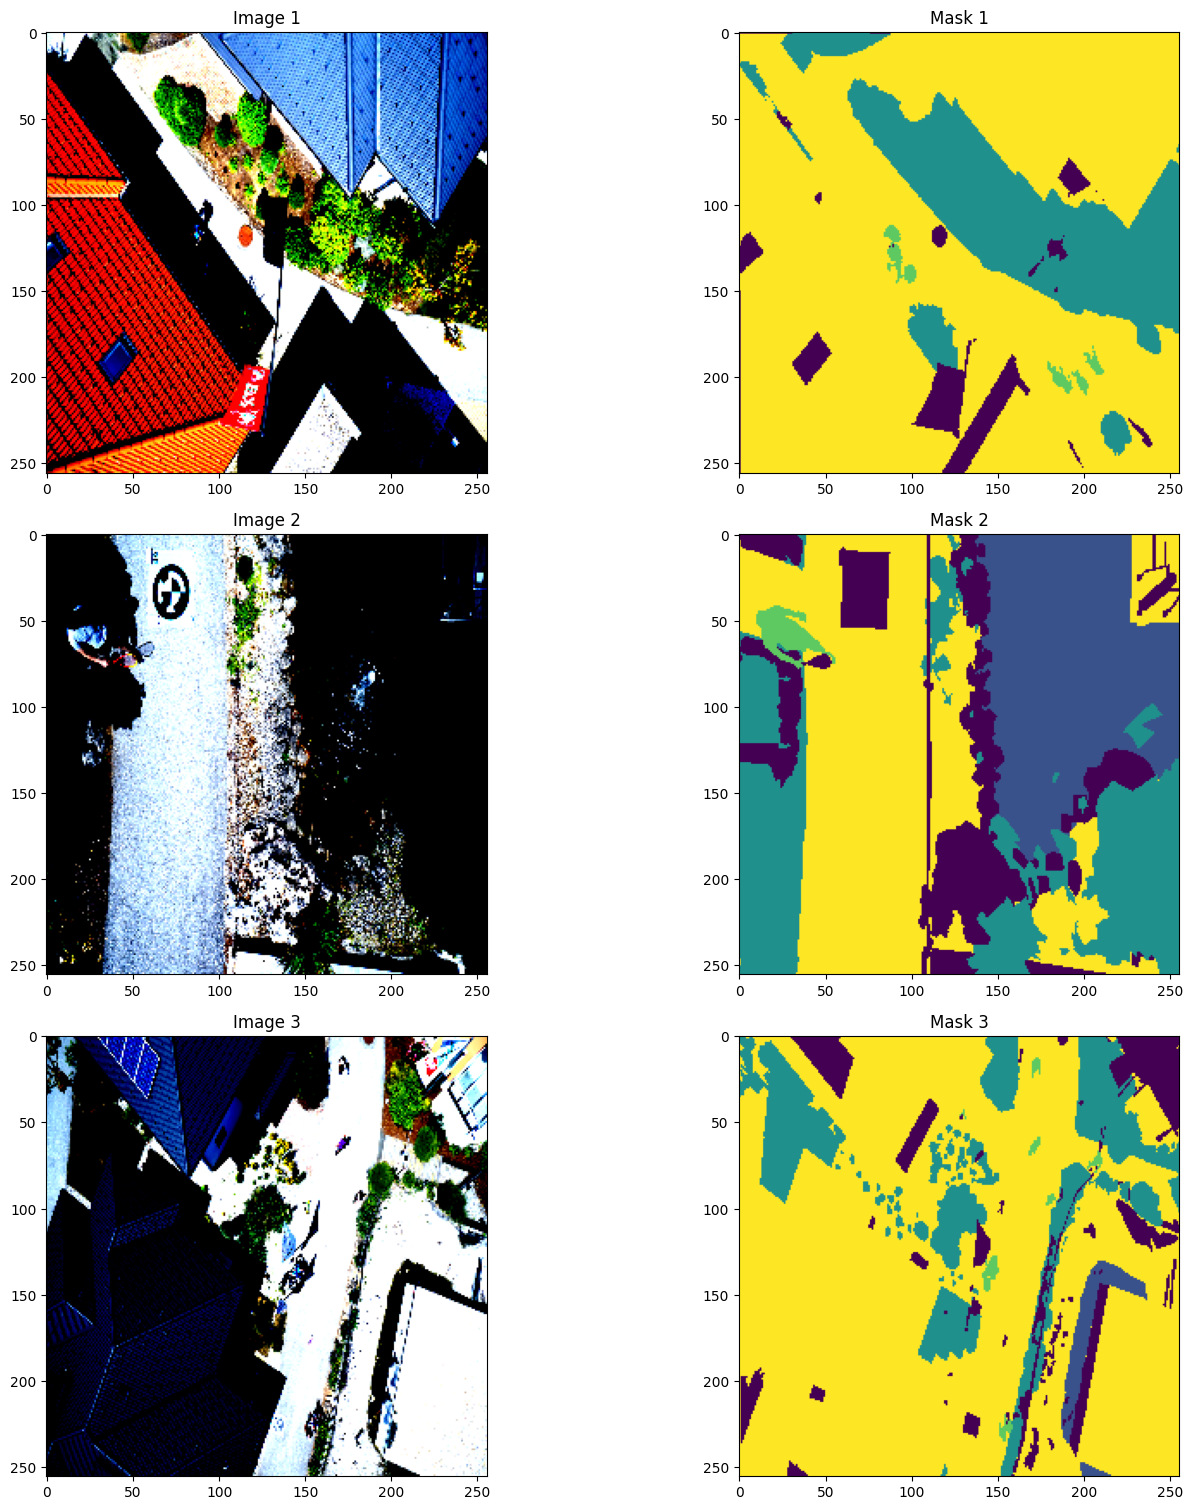

In [24]:
display_samples(train_dataset)

### b. Метрики качества

В качестве метрик для данной задачи будут использоваться:
   
$$ \text{Pixel Accuracy} = \frac{\text{Количество правильно классифицированных пикселей}}{\text{Общее количество пикселей}} $$

- Измеряет долю правильно классифицированных пикселей в изображении.

$$ \text{Intersection over Union (IoU)} = \frac{|A \cap B|}{|A \cup B|} $$

- Измеряет отношение площади пересечения к площади объединения двух наборов. Это также значение от 0 до 1, где 1 указывает на полное совпадение.

$$ \text{Dice Score} = \frac{2 |A \cap B|}{|A| + |B|} $$

- Измеряет сходство между предсказанными и истинными сегментами, учитывая пересечение дважды. Значения варьируются от 0 до 1, где 1 означает полное совпадение.

In [8]:
import torch


def calculate_metrics(outputs, masks, num_classes):
    with torch.no_grad():
        preds = torch.argmax(outputs, dim=1)

        # Считаем Accuracy
        correct = (preds == masks).float()
        accuracy = correct.sum() / correct.numel()

        # Находим IoU и Dice по каждому классу
        ious = []
        dices = []
        for cls in range(num_classes):
            pred_inds = (preds == cls)
            target_inds = (masks == cls)

            intersection = (pred_inds & target_inds).sum().float()
            union = (pred_inds | target_inds).sum().float()
            iou = intersection / union if union > 0 else torch.tensor(1.0)

            dice = 2 * intersection / (pred_inds.sum().float() + target_inds.sum().float()) if (pred_inds.sum() + target_inds.sum()) > 0 else torch.tensor(1.0)

            ious.append(iou)
            dices.append(dice)

        mean_iou = torch.stack(ious).mean()
        mean_dice = torch.stack(dices).mean()

    return accuracy.item(), mean_iou.item(), mean_dice.item()

## 2. Создание бейзлайна и оценка качества

In [9]:
def train_model(model, criterion, optimizer, train_loader, val_loader, device, num_classes, num_epochs=10):
    model = model.to(device)
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_acc_sum = 0
        train_iou_sum = 0
        train_dice_sum = 0
        train_batches = 0

        for images, masks in train_loader:
            images = images.to(device)
            masks = masks.squeeze(1).long().to(device)

            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            acc, iou, dice = calculate_metrics(outputs, masks, num_classes)
            train_acc_sum += acc
            train_iou_sum += iou
            train_dice_sum += dice

            train_batches += 1

        avg_train_loss = train_loss / train_batches
        avg_train_acc = train_acc_sum / train_batches
        avg_train_iou = train_iou_sum / train_batches
        avg_train_dice = train_dice_sum / train_batches

        model.eval()
        val_loss = 0
        val_acc_sum = 0
        val_iou_sum = 0
        val_dice_sum = 0
        val_batches = 0

        with torch.no_grad():
            for images_val, masks_val in val_loader:
                images_val = images_val.to(device)
                masks_val = masks_val.squeeze(1).long().to(device)

                outputs_val = model(images_val)
                loss_val = criterion(outputs_val, masks_val)

                val_loss += loss_val.item()

                acc_val, iou_val, dice_val = calculate_metrics(outputs_val, masks_val, num_classes)
                val_acc_sum += acc_val
                val_iou_sum += iou_val
                val_dice_sum += dice_val

                val_batches += 1

        avg_val_loss = val_loss / val_batches
        avg_val_acc = val_acc_sum / val_batches
        avg_val_iou = val_iou_sum / val_batches
        avg_val_dice = val_dice_sum / val_batches

        print(f"- Эпоха {epoch+1} -")
        print(f"*Train* Loss: {avg_train_loss:.3f} Acc: {avg_train_acc:.3f} IoU: {avg_train_iou:.3f} Dice: {avg_train_dice:.3f}")
        print(f"*Val* Loss: {avg_val_loss:.3f} Acc: {avg_val_acc:.3f} IoU: {avg_val_iou:.3f} Dice: {avg_val_dice:.3f}\n")

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Для решения задачи сегментации будем использовать архитектуру U-Net с предобученным энкодером ResNet34.
Для базового случая не будем применять трансформации такие как отображени, шум и прочее к исходным данным, learning rate зададим как 0.001 и в качестве функции потерь будем использовать CrossEntropyLoss.

In [58]:
num_classes = 5
learning_rate = 0.001

model = smp.Unet(
    encoder_name="resnet34",
    classes=num_classes,
    encoder_weights="imagenet",
    activation=None,
    decoder_channels=[256, 128, 64, 32, 16]
)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Проведем дообучение модели на 10 эпохах.

In [59]:
train_model(model,criterion, optimizer, train_loader, val_loader, device, num_classes, num_epochs=10)

- Эпоха 1 -
*Train* Loss: 1.303 Acc: 0.526 IoU: 0.180 Dice: 0.237
*Val* Loss: 1.245 Acc: 0.768 IoU: 0.316 Dice: 0.367

- Эпоха 2 -
*Train* Loss: 0.724 Acc: 0.765 IoU: 0.303 Dice: 0.356
*Val* Loss: 0.641 Acc: 0.794 IoU: 0.337 Dice: 0.383

- Эпоха 3 -
*Train* Loss: 0.613 Acc: 0.780 IoU: 0.314 Dice: 0.364
*Val* Loss: 0.635 Acc: 0.785 IoU: 0.341 Dice: 0.391

- Эпоха 4 -
*Train* Loss: 0.582 Acc: 0.794 IoU: 0.328 Dice: 0.387
*Val* Loss: 0.615 Acc: 0.798 IoU: 0.353 Dice: 0.407

- Эпоха 5 -
*Train* Loss: 0.554 Acc: 0.799 IoU: 0.329 Dice: 0.392
*Val* Loss: 0.594 Acc: 0.808 IoU: 0.337 Dice: 0.399

- Эпоха 6 -
*Train* Loss: 0.551 Acc: 0.801 IoU: 0.348 Dice: 0.415
*Val* Loss: 0.605 Acc: 0.766 IoU: 0.358 Dice: 0.419

- Эпоха 7 -
*Train* Loss: 0.536 Acc: 0.809 IoU: 0.352 Dice: 0.420
*Val* Loss: 0.592 Acc: 0.802 IoU: 0.348 Dice: 0.409

- Эпоха 8 -
*Train* Loss: 0.501 Acc: 0.817 IoU: 0.373 Dice: 0.446
*Val* Loss: 0.657 Acc: 0.788 IoU: 0.366 Dice: 0.435

- Эпоха 9 -
*Train* Loss: 0.489 Acc: 0.819 IoU: 

Dice стабильно рос на обеих выборках. Pixel Accuracy показала достаточно всокий уровень как на тренировочной, так и на валидационной выборке (0.7-0.8). Loss сначала стабильно уменьшался на валидации, но где-то в середине начал "скакать", возможно имело место переобучение. Для повышения показателей модели и более качественного обучения попробуем улучшить бейзлайн.

## 3. Улучшение бейзлайна

Повысить точность при обучении могут помочь следующие способы:

* Аугментация данных

Для увеличения количества входных данных и улучшения обучения моделей можно расширить датасет путем применения горизонтального/вертикального отражения, случайных поворотов, масштабирования, изменения яркости и контраста, обрезки и наложения шумов.

* Настройка гиперпараметров

Изменение learning rate, применение более продвинутых оптимизаторов и функций потерь, увеличение количества эпох обучения могут также способствовать улучшению результатов.

Попробуем виспользовать более сложную функции потерь. Объединим CrossEntropyLoss с Dice Loss, это может помочь лучше справляться с несбалансированными классами.

In [11]:
class CombinedLoss(nn.Module):
    def __init__(self, ce_weight=0.5, dice_weight=0.5):
        super(CombinedLoss, self).__init__()
        self.ce_weight = ce_weight
        self.dice_weight = dice_weight
        self.cross_entropy_loss = nn.CrossEntropyLoss()

    def dice_loss(self, predictions, targets, num_classes=11, smooth=1e-6):
        predictions = predictions.argmax(dim=1)
        dice_score = 0.0

        for class_index in range(num_classes):
            predicted_mask = (predictions == class_index).float()
            target_mask = (targets == class_index).float()
            intersection = (predicted_mask * target_mask).sum()
            dice_score += (2. * intersection + smooth) / (predicted_mask.sum() + target_mask.sum() + smooth)

        return dice_score / num_classes

    def forward(self, outputs, targets):
        ce_loss = self.cross_entropy_loss(outputs, targets)
        d_loss = self.dice_loss(outputs, targets)
        return self.ce_weight * ce_loss + self.dice_weight * d_loss

Также будем использовать аугментацию данных на тренировочном наборе, применим такие преобразования как горизонтальное отражение, вертикальное отражение, наложение Гауссова шума, изменение сетки, яркости и контраста.

In [12]:
batch_size = 8

improved_data_transforms = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.GaussNoise(),
    A.GridDistortion(p=0.2),
    A.RandomBrightnessContrast((0,0.5),(0,0.5), p=0.4)])

improved_train_dataset = DroneDataset(image_path, mask_path, X_train, improved_data_transforms)
improved_valid_dataset = DroneDataset(image_path, mask_path, X_val)

improved_train_loader = DataLoader(improved_train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
improved_val_loader = DataLoader(improved_valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

Поменяем энкодер на более продвинутый resnet50, уменьшим learning rate до 0.0001 и увеличим число эпох для тренировки до 15.

In [62]:
num_classes = 5
learning_rate = 0.0001

improved_model = smp.Unet(
    encoder_name="resnet50",
    classes=num_classes,
    encoder_weights="imagenet"
)
improved_model.to(device)

improved_criterion = CombinedLoss()
improved_optimizer = torch.optim.Adam(improved_model.parameters(), lr=learning_rate)

In [63]:
train_model(improved_model, improved_criterion, improved_optimizer, improved_train_loader, improved_val_loader, device, num_classes, num_epochs=15)

- Эпоха 1 -
*Train* Loss: 0.928 Acc: 0.581 IoU: 0.216 Dice: 0.294
*Val* Loss: 0.768 Acc: 0.796 IoU: 0.316 Dice: 0.375

- Эпоха 2 -
*Train* Loss: 0.791 Acc: 0.733 IoU: 0.278 Dice: 0.344
*Val* Loss: 0.683 Acc: 0.807 IoU: 0.318 Dice: 0.372

- Эпоха 3 -
*Train* Loss: 0.733 Acc: 0.761 IoU: 0.292 Dice: 0.352
*Val* Loss: 0.664 Acc: 0.817 IoU: 0.323 Dice: 0.373

- Эпоха 4 -
*Train* Loss: 0.716 Acc: 0.757 IoU: 0.295 Dice: 0.362
*Val* Loss: 0.650 Acc: 0.805 IoU: 0.313 Dice: 0.365

- Эпоха 5 -
*Train* Loss: 0.690 Acc: 0.770 IoU: 0.305 Dice: 0.371
*Val* Loss: 0.625 Acc: 0.817 IoU: 0.325 Dice: 0.379

- Эпоха 6 -
*Train* Loss: 0.680 Acc: 0.779 IoU: 0.321 Dice: 0.393
*Val* Loss: 0.609 Acc: 0.832 IoU: 0.356 Dice: 0.423

- Эпоха 7 -
*Train* Loss: 0.681 Acc: 0.789 IoU: 0.361 Dice: 0.446
*Val* Loss: 0.616 Acc: 0.846 IoU: 0.403 Dice: 0.474

- Эпоха 8 -
*Train* Loss: 0.667 Acc: 0.801 IoU: 0.384 Dice: 0.472
*Val* Loss: 0.604 Acc: 0.855 IoU: 0.435 Dice: 0.515

- Эпоха 9 -
*Train* Loss: 0.665 Acc: 0.804 IoU: 

С улучшенным бэйзлайном удалось добиться существенных повышений значений основных метрик.
На валидационном наборе Pixel Accuracy достигло значения 0.872, IoU - 0.480 и Dice - 0.566. Следовательно, примененные способы по повышению качества модели, действительно дали свои результаты.

## 4. Имплементация алгоритма машинного обучения

Попробуем написать свою реализацию модели U-Net. Такая модель состоит из двух основных частей: кодировщика и декодировщика, а также включает в себя skip connections для сохранения информации на разных уровнях.

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Класс для создания простого блока свертки
class SimpleConvolutionalBlock(nn.Module):
    def __init__(self, input_channels, output_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


# Собственный класс Unet модели
class MyUNet(nn.Module):
    def __init__(self, output_channels=1, feature_sizes=[32, 64, 128]):
        super().__init__()
        self.encoder_blocks = nn.ModuleList()
        self.pooling_layer = nn.MaxPool2d(kernel_size=2, stride=2)

        input_channels = 3
        for feature_size in feature_sizes:
            self.encoder_blocks.append(SimpleConvolutionalBlock(input_channels, feature_size))
            input_channels = feature_size

        self.bottleneck_block = SimpleConvolutionalBlock(feature_sizes[-1], feature_sizes[-1] * 2)

        self.upconvolution_layers = nn.ModuleList()
        self.decoder_blocks = nn.ModuleList()

        for feature_size in reversed(feature_sizes):
            self.upconvolution_layers.append(nn.ConvTranspose2d(feature_size * 2, feature_size, kernel_size=2, stride=2))
            self.decoder_blocks.append(SimpleConvolutionalBlock(feature_size * 2, feature_size))

        self.final_convolution = nn.Conv2d(feature_sizes[0], output_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        # Encoder
        for encoder_block in self.encoder_blocks:
            x = encoder_block(x)
            skip_connections.append(x)
            x = self.pooling_layer(x)

        x = self.bottleneck_block(x)

        skip_connections.reverse()

        # Decoder
        for idx in range(len(self.upconvolution_layers)):
            x = self.upconvolution_layers[idx](x)
            skip_connection = skip_connections[idx]

            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:])

            x = torch.cat((skip_connection, x), dim=1)
            x = self.decoder_blocks[idx](x)

        return self.final_convolution(x)

Обучим сначала эту модель на исходных данных без преобразований и улучшений.

In [17]:
num_classes = 5
learning_rate = 0.001

my_model = MyUNet(output_channels=num_classes)
my_model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(my_model.parameters(), lr=learning_rate)

In [18]:
train_model(my_model, criterion, optimizer, train_loader, val_loader, device, num_classes, num_epochs=10)

- Эпоха 1 -
*Train* Loss: 1.018 Acc: 0.687 IoU: 0.274 Dice: 0.349
*Val* Loss: 0.978 Acc: 0.718 IoU: 0.284 Dice: 0.344

- Эпоха 2 -
*Train* Loss: 0.717 Acc: 0.770 IoU: 0.316 Dice: 0.377
*Val* Loss: 0.621 Acc: 0.802 IoU: 0.359 Dice: 0.419

- Эпоха 3 -
*Train* Loss: 0.651 Acc: 0.784 IoU: 0.322 Dice: 0.383
*Val* Loss: 0.635 Acc: 0.782 IoU: 0.329 Dice: 0.393

- Эпоха 4 -
*Train* Loss: 0.626 Acc: 0.785 IoU: 0.315 Dice: 0.379
*Val* Loss: 0.568 Acc: 0.806 IoU: 0.323 Dice: 0.378

- Эпоха 5 -
*Train* Loss: 0.580 Acc: 0.801 IoU: 0.331 Dice: 0.394
*Val* Loss: 0.614 Acc: 0.795 IoU: 0.332 Dice: 0.401

- Эпоха 6 -
*Train* Loss: 0.564 Acc: 0.801 IoU: 0.334 Dice: 0.400
*Val* Loss: 0.596 Acc: 0.796 IoU: 0.329 Dice: 0.396

- Эпоха 7 -
*Train* Loss: 0.584 Acc: 0.791 IoU: 0.339 Dice: 0.409
*Val* Loss: 0.539 Acc: 0.811 IoU: 0.337 Dice: 0.401

- Эпоха 8 -
*Train* Loss: 0.555 Acc: 0.802 IoU: 0.338 Dice: 0.405
*Val* Loss: 0.662 Acc: 0.757 IoU: 0.336 Dice: 0.414

- Эпоха 9 -
*Train* Loss: 0.568 Acc: 0.792 IoU: 

В результате обучения модели собственной реализации при простом бейзлайне результаты получились даже лучше, чем при использовании U-net из библиотеки. Наверняка на улучшенном бейзлайне также удастся еще повысить значения исходных метрик.

Для улучшения показателей модели будем использовать для тренировки данные с аугментацией, комбинированную функцию потерь и learning rate = 0.0001.

In [15]:
num_classes = 5
learning_rate = 0.0001

improved_my_model = MyUNet(output_channels=num_classes)
improved_my_model.to(device)

improved_criterion = CombinedLoss()
improved_optimizer = torch.optim.Adam(improved_my_model.parameters(), lr=learning_rate)

Запустим обучение на 15 эпохах.

In [16]:
train_model(improved_my_model, improved_criterion, improved_optimizer, improved_train_loader, improved_val_loader, device, num_classes, num_epochs=15)

- Эпоха 1 -
*Train* Loss: 1.109 Acc: 0.263 IoU: 0.120 Dice: 0.188
*Val* Loss: 1.023 Acc: 0.556 IoU: 0.251 Dice: 0.336

- Эпоха 2 -
*Train* Loss: 1.021 Acc: 0.532 IoU: 0.226 Dice: 0.308
*Val* Loss: 0.943 Acc: 0.704 IoU: 0.297 Dice: 0.376

- Эпоха 3 -
*Train* Loss: 0.976 Acc: 0.633 IoU: 0.252 Dice: 0.328
*Val* Loss: 0.939 Acc: 0.698 IoU: 0.285 Dice: 0.365

- Эпоха 4 -
*Train* Loss: 0.936 Acc: 0.677 IoU: 0.265 Dice: 0.338
*Val* Loss: 0.863 Acc: 0.757 IoU: 0.327 Dice: 0.396

- Эпоха 5 -
*Train* Loss: 0.911 Acc: 0.696 IoU: 0.268 Dice: 0.337
*Val* Loss: 0.839 Acc: 0.746 IoU: 0.312 Dice: 0.380

- Эпоха 6 -
*Train* Loss: 0.890 Acc: 0.692 IoU: 0.257 Dice: 0.324
*Val* Loss: 0.825 Acc: 0.774 IoU: 0.311 Dice: 0.375

- Эпоха 7 -
*Train* Loss: 0.869 Acc: 0.707 IoU: 0.262 Dice: 0.328
*Val* Loss: 0.821 Acc: 0.725 IoU: 0.270 Dice: 0.341

- Эпоха 8 -
*Train* Loss: 0.852 Acc: 0.711 IoU: 0.265 Dice: 0.328
*Val* Loss: 0.791 Acc: 0.788 IoU: 0.311 Dice: 0.369

- Эпоха 9 -
*Train* Loss: 0.836 Acc: 0.717 IoU: 

Предположение о том, что при применении аугментации, изменении шага обучения и количества эпох удастся добиться более высоких показателей по метрикам оценки у самостоятельно реализованной модели, оказалось ошибочным. Модель обучилась хуже чем на стандартном бейзлайне, думаю нужно было еще поиграться с параметрами и улучшить реализацию, так как написана она сейчас очень упрощенно, соответственно сеть сильно проигрывает по показателям U-Net из библиотеки.

## Выводы

В результате выполнения данной лабораторной работы было проведено исследование архитектуры U-Net для задач семантической сегментаци и была написана своя собственная реализация модели. Дообученная сеть U-Net показывает очень хорошие результаты, особенно при использовании энкодера resnet50. Таких же хороших результатов при самостоятельной реализации добиться не удалось, но это в принципе ожидаемо так как свою сеть приходилось обучать с нуля.